rhesus
Total annotated: 12437
Pct. annotated: 81
Pct. mammal false  0.91
Pct. euk true  0.21
mouse
Total annotated: 15068
Pct. annotated: 81
Pct. mammal false  0.19
Pct. euk true  0.08
human
Total annotated: 17115
Pct. annotated: 97
Pct. mammal false  0.52
Pct. euk true  0.07
Gene age plot created


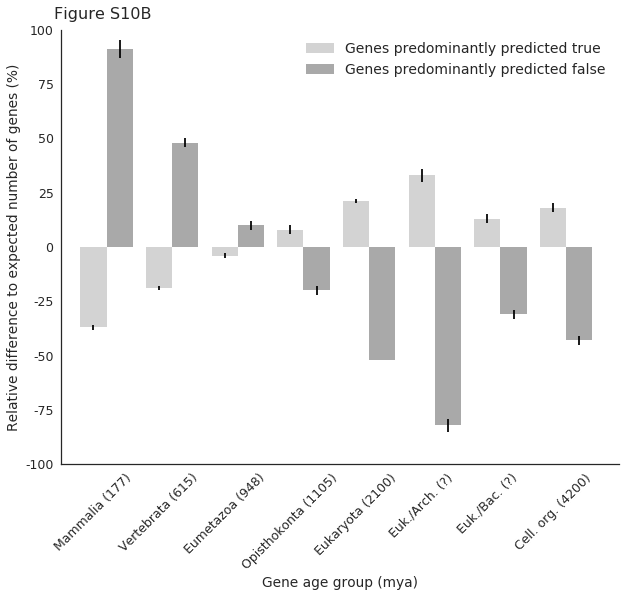

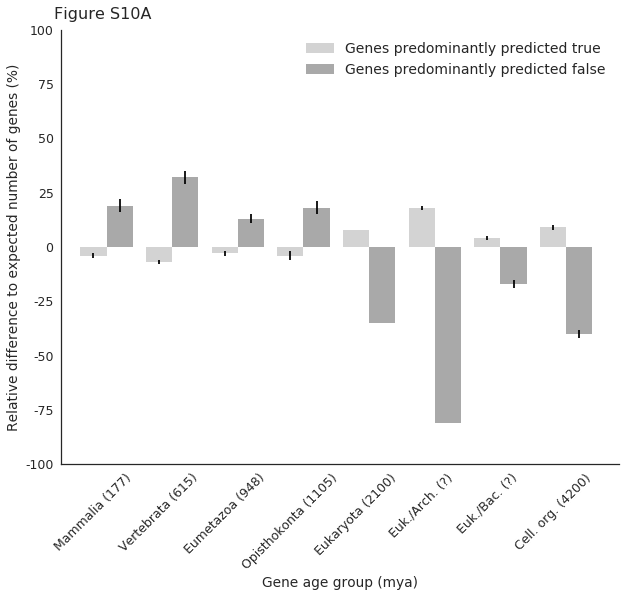

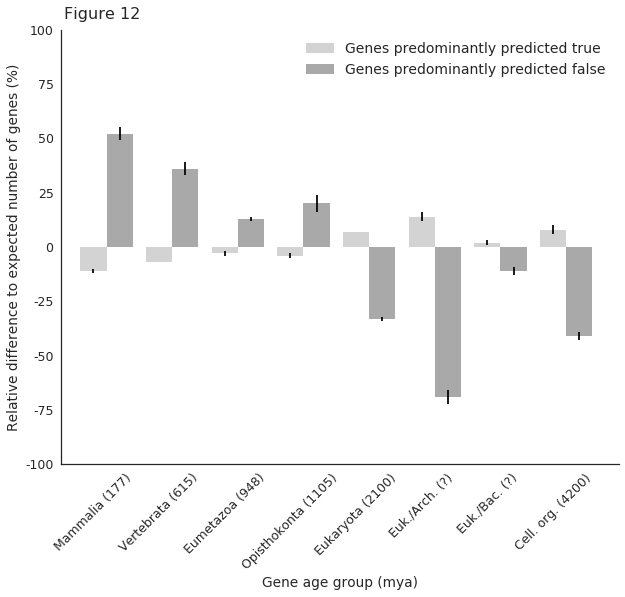

In [9]:
%matplotlib inline

import os as os
import numpy as np
import numpy.random as rng
import json as js
import csv as csv
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import warnings as warn
import itertools as itt

import sklearn.exceptions as skle

warn.filterwarnings('error', message='Precision.+', category=skle.UndefinedMetricWarning)

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import ttest_1samp as tt

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

date = '20180316'

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'
ref_folder = '/home/pebert/work/code/mpggit/refdata/annotation'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))
lca_times_file = os.path.join(ref_folder, 'lca_dist.tsv')
species_file = os.path.join(ref_folder, 'species.tsv')

prep_date = '20180313'
gene_age_files = {'human': os.path.join(fhgfs_base, 'refdata/geneage/norm/{}_human_agefeat.h5'.format(prep_date)),
                  'mouse': os.path.join(fhgfs_base, 'refdata/geneage/norm/{}_mouse_agefeat.h5'.format(prep_date)),
                  'cow': os.path.join(fhgfs_base, 'refdata/geneage/norm/{}_cow_agefeat.h5'.format(prep_date)),
                  'rhesus': os.path.join(fhgfs_base, 'refdata/geneage/norm/{}_rhesus_agefeat.h5'.format(prep_date)),
                  'rat': os.path.join(fhgfs_base, 'refdata/geneage/norm/{}_rat_agefeat.h5'.format(prep_date))}

gene_model_files = {'human': os.path.join(fhgfs_base, 'refdata/genemodel/subsets/protein_coding/roi_hdf/hsa_hg19_gencode_v19.body.h5'),
                    'mouse': os.path.join(fhgfs_base, 'refdata/genemodel/subsets/protein_coding/roi_hdf/mmu_mm9_gencode_vM1.body.h5'),
                    'cow': os.path.join(fhgfs_base, 'refdata/genemodel/subsets/protein_coding/roi_hdf/bta_bosTau7_ensembl_v75.body.h5'),
                    'rhesus': os.path.join(fhgfs_base, 'refdata/genemodel/subsets/protein_coding/roi_hdf/mcc_rheMac2_ensembl_v81.body.h5'),
                    'rat': os.path.join(fhgfs_base, 'refdata/genemodel/subsets/protein_coding/roi_hdf/rno_rn5_ensembl_v79.body.h5')}

run_exec_gene_ages = True
show_figures = True

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
save_figures = True

gene_ages = [('Eumetazoa', 948), ('Eukaryota', 2100),
             ('Vertebrata', 615), ('Opisthokonta', 1105),
             ('Mammalia', 177), ('Euk./Bac.', 3500),
             ('Euk./Arch.', 3000), ('Cell. org.', 4200)]

age_labels = {'Eumetazoa': 948, 'Eukaryota': 2100,
              'Vertebrata': 615, 'Opisthokonta': 1105,
              'Mammalia': 177, 'Euk./Bac.': '?',
              'Euk./Arch.': '?', 'Cell. org.': 4200}

group_labels = {'ftage_bin_eumeta': 'Eumetazoa', 'ftage_bin_euk': 'Eukaryota',
                'ftage_bin_vert': 'Vertebrata', 'ftage_bin_opist': 'Opisthokonta',
                'ftage_bin_mamm': 'Mammalia', 'ftage_bin_eukbac': 'Euk./Bac.',
                'ftage_bin_eukarch': 'Euk./Arch.', 'ftage_bin_cellorg': 'Cell. org.',
                'ftcons_pct_body': 'Aln. body', 'ftcons_pct_reg5p': 'Aln. promoter'}

def exec_gene_ages():
    fig_keys = {'human': '12', 'mouse': 'S10A', 'rhesus': 'S10B'}
    for spec, fp in gene_age_files.items():
        if spec not in ['human', 'mouse', 'rhesus']:
            continue
        with pd.HDFStore(fp, 'r') as hdf:
            if spec in ['cow', 'rhesus']:
                load_key = [k for k in hdf.keys() if k.endswith('joint/final')]
            else:
                load_key = [k for k in hdf.keys() if k.endswith('/final')]
            load_key = load_key[0]
            age_data = hdf[load_key]
            to_drop = [c for c in age_data.columns if c.startswith('ftconf') or c.startswith('ftage_abs')]
            age_data.drop(to_drop, inplace=True, axis=1)
        gene_file = gene_model_files[spec]
        total_genes = 0
        with pd.HDFStore(gene_file, 'r') as hdf:
            md = hdf['metadata']
            total_genes = int(md['numreg'].sum())
                    
        spec_color = plot_colors['species'][spec]['rgb']
        annot_genes = age_data.shape[0]
        pct_annot = int(np.round(annot_genes / total_genes, 2) * 100)
        
        group_priors = collect_group_priors(age_data)
        group_stats = collect_group_statistics(age_data)
        
        ### For publication
        print('=======')
        print(spec)
        print('Total annotated: {}'.format(annot_genes))
        print('Pct. annotated: {}'.format(pct_annot))
        
#         title = '{} {} genes by age ({}% annotated)'.format(annot_genes, spec, 
#                                                             pct_annot)
        fk = fig_keys[spec]
        title = 'Figure {}'.format(fk)
        fig, exart = plot_count_bars(group_stats, group_priors, title)
        if save_figures:
            outname = 'fig_{}_gene-age_{}'.format(fk, spec)
            if spec == 'human':
                subfolder = 'main'
            else:
                subfolder = 'supp'
            
            outpath = os.path.join(out_folder, subfolder, 'raw', outname + '.svg')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
            
            outpath = os.path.join(out_folder, subfolder, 'png', outname + '.png')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
            
            outpath = os.path.join(out_folder, subfolder, outname + '.pdf')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
            
    return True


def collect_group_priors(dataset):
    """
    """
    true_frac = np.round((dataset.loc[dataset['target'] > 0.5, :]).shape[0] / dataset.shape[0], 2)
    false_frac = np.round(1 - true_frac, 2)
    group_priors = dict()
    for age_group in group_labels.keys():
        if '_pct_' in age_group:
            continue
        total_group = dataset[age_group].sum()
        group_true = np.round(total_group * true_frac, 0)
        group_false = total_group - group_true
        group_priors[age_group] = {'true': group_true, 'false': group_false}

    return group_priors


def collect_group_statistics(dataset):
    """
    """
    stats = {}
    for group in group_labels.keys():
        if '_pct_' in group:
            continue
        subset = dataset.loc[dataset[group] > 0, :].copy()
        true_group = subset.loc[subset['target'] > 0.5, :]
        true_num = true_group.shape[0]
        false_group = subset.loc[subset['target'] <= 0.5, :]
        false_num = false_group.shape[0]
        stats[group] = {'true_num': true_num, 'false_num': false_num}
        
        # make 1000 bootstraps to estimate the spread
        # of the groups
        for label, groupsize in zip(['true', 'false'],
                                    [true_num, false_num]):
            bs = rng.choice(subset['target'].values,
                            size=(1000, groupsize), replace=True)
            if label == 'true':
                bs = (bs > 0.5).sum(axis=1)
            else:
                bs = (bs <= 0.5).sum(axis=1)
            bs_est_std = bs.std()
            stats[group][label + '_std'] = np.round(bs_est_std, 0)
    return stats
    
    
def plot_count_bars(group_data, group_priors, title):
    """
    """
    inv_lut = dict((v, k) for k, v in group_labels.items())
    sort_order = sorted(gene_ages, key=lambda t: t[1])
    
    barwidth = 0.2
    
    mammal_idx = 0
    euk_idx = 4
    
    glabels = []
    x_ticks = []
    true_x, false_x = [],[]
    true_hts, false_hts = [], []
    true_errs, false_errs = [], []
    
    x_val = 0.25
    for gname, _ in sort_order:
        glabels.append(gname + ' ({})'.format(age_labels[gname]))
        ftname = inv_lut[gname]
        
        true_prior = group_priors[ftname]['true']
        true_ht = group_data[ftname]['true_num']
        true_err = group_data[ftname]['true_std']
        true_rel_ht = np.round(true_ht / true_prior, 2)
        true_rel_err = np.round((true_ht + true_err) / true_prior, 2)
        true_rel_err = np.abs(true_rel_err - true_rel_ht)
        if true_rel_ht < 1:
            true_rel_ht = -1 + true_rel_ht
            true_rel_err *= -1
        else:
            true_rel_ht -= 1
        
        true_x.append(x_val)
        true_hts.append(true_rel_ht)
        true_errs.append(true_rel_err)
        
        x_ticks.append(x_val)
        x_val += barwidth
        
        false_prior = group_priors[ftname]['false']
        false_ht = group_data[ftname]['false_num']
        false_err = group_data[ftname]['false_std']
        false_rel_ht = np.round(false_ht / false_prior, 2)
        false_rel_err = np.round((false_ht + false_err) / false_prior, 2)
        false_rel_err = np.abs(false_rel_err - false_rel_ht)
        if false_rel_ht < 1:
            false_rel_ht = -1 + false_rel_ht
            false_rel_err *= -1
        else:
            false_rel_ht -= 1
        
        false_x.append(x_val)
        false_hts.append(false_rel_ht)
        false_errs.append(false_rel_err)
        
        x_val += 1.5 * barwidth
    
    ### for publication
    print('Pct. mammal false ', false_hts[mammal_idx].round(2))
    print('Pct. euk true ', true_hts[euk_idx].round(2))
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(0, x_val)
    ax.set_ylim(-1, 1)
    
    y_ticks = np.arange(-1, 1.25, 0.25)
    y_labels = map(str, [int(x * 100) for x in y_ticks])

    ax.bar(true_x, true_hts, color='lightgrey', width=barwidth, yerr=true_errs,
           label='Genes predominantly predicted true')
    ax.bar(false_x, false_hts, color='darkgrey', width=barwidth, yerr=false_errs,
           label='Genes predominantly predicted false')
        
    ax.legend(fontsize=14)
        
    ax.set_ylabel('Relative difference to expected number of genes (%)')
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    
    ax.set_xlabel('Gene age group (mya)')
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(glabels, rotation=45)
    
    tt = ax.set_title(title, fontsize=16)
    tt.set_position([0.075, 1.01])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return fig, []
   
    
if run_exec_gene_ages:
    execd = exec_gene_ages()
    print('Gene age plot created')
